# Hamiltonian Monte Carlo (HMC) approximation for beta-bernouli model 
author: @karm-patel


In this notebook, we approximate posterior of beta-bernouli model using HMC approximation. HMC is markov chain monte carlo (MCMC) algorithm.

In [1]:
import jax
import jax.numpy as jnp
from jax import lax

try:
    from probml_utils import latexify, savefig
except:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig

from probml_utils.blackjax_utils import arviz_trace_from_states, inference_loop_multiple_chains

try:
    import blackjax
except:
    %pip install blackjax
    import blackjax

try:
    from tensorflow_probability.substrates import jax as tfp
except ModuleNotFoundError:
    %pip install -qqq tensorflow_probability
    from tensorflow_probability.substrates import jax as tfp

try:
    from rich import print
except ModuleNotFoundError:
    %pip install -qqq rich
    from rich import print

import arviz as az
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings("ignore")
dist = tfp.distributions

plt.rc("font", size=10)  # controls default text sizes
plt.rc("axes", labelsize=12)  # fontsize of the x and y labels
plt.rc("legend", fontsize=12)  # legend fontsize
plt.rc("figure", titlesize=15)  # fontsize of the figure title

In [2]:
latexify(width_scale_factor=1, fig_height=1.5)  # to apply latexify, set LATEXIFY=1 in environment variable

In [3]:
# helper functions
def prior_dist():
    return dist.Beta(concentration1=1.0, concentration0=1.0)


def likelihood_dist(theta):
    return dist.Bernoulli(probs=theta)

## Dataset

In [4]:
# Use same data as https://github.com/probml/probml-notebooks/blob/main/notebooks/beta_binom_approx_post_pymc.ipynb
key = jax.random.PRNGKey(128)
dataset = np.repeat([0, 1], (10, 1))
n_samples = len(dataset)
print(f"Dataset: {dataset}")
n_heads = dataset.sum()
n_tails = n_samples - n_heads

Dataset: [0 0 0 0 0 0 0 0 0 0 1]

## Prior, Likelihood, and True Posterior  
For coin toss problem, since we know the closed form solution of posterior, we compare the distributions of Prior, Likelihood, and True Posterior below.

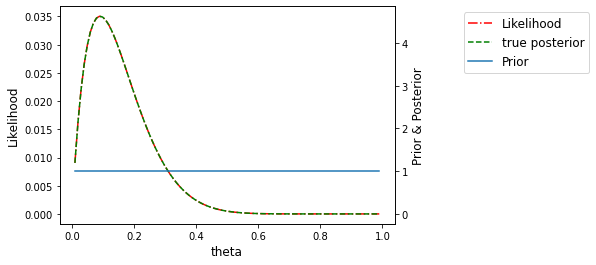

In [5]:
# closed form of beta posterior
a = prior_dist().concentration1
b = prior_dist().concentration0

exact_posterior = dist.Beta(concentration1=a + n_heads, concentration0=b + n_tails)

theta_range = jnp.linspace(0.01, 0.99, 100)

ax = plt.gca()
ax2 = ax.twinx()
posterior_prob = exact_posterior.prob(theta_range)
(plt2,) = ax2.plot(theta_range, posterior_prob, "g--", label="true posterior")
(plt3,) = ax2.plot(theta_range, prior_dist().prob(theta_range), label="Prior")

theta_map = theta_range[jnp.argmax(posterior_prob)]
y_max = posterior_prob.max()
# plt4 = ax2.vlines(theta_map,0,y_max ,label=f"$\\theta\_map={round(theta_map,2)}$", color="black", linestyle="-.")

likelihood = jax.vmap(lambda x: jnp.prod(likelihood_dist(x).prob(dataset)))(theta_range)
(plt1,) = ax.plot(theta_range, likelihood, "r-.", label="Likelihood")

ax.set_xlabel("theta")
ax.set_ylabel("Likelihood")
ax2.set_ylabel("Prior & Posterior")
ax2.legend(handles=[plt1, plt2, plt3], bbox_to_anchor=(1.6, 1));

## NUTS using Blackjax
Reference: https://blackjax-devs.github.io/blackjax/examples/Introduction.html

In [70]:
def logprob_fn(params):
    theta = params["theta"]
    likelihood_log_prob = likelihood_dist(theta).log_prob(dataset).sum()  # log probability of likelihood
    prior_log_prob = prior_dist().log_prob(theta)  # log probability of prior
    return likelihood_log_prob + prior_log_prob  # log_prior_liklihood

In [100]:
inv_mass_matrix = jnp.array([0.1])
step_size = 0.01

nuts = blackjax.nuts(logprob_fn, step_size, inv_mass_matrix)

In [101]:
n_chains = 4
rng_key = jax.random.PRNGKey(0)
# initial_positions = {"theta": jax.random.uniform(key = rng_key, shape=(n_chains,))}
initial_positions = {"theta": jnp.array([0.99, 0.95, 0.5, 0.8])}
initial_states = jax.vmap(nuts.init)(initial_positions)
kernel = jax.jit(nuts.step)

In [102]:
%%time
n_samples = 1000
rng_key = jax.random.PRNGKey(1)
chain_states, infos = inference_loop_multiple_chains(rng_key, kernel, initial_states, n_samples, n_chains)

CPU times: user 3.24 s, sys: 74 ms, total: 3.32 s
Wall time: 3.26 s


In [103]:
chains = chain_states.position["theta"]

In [104]:
chains.shape

(1000, 4)

In [105]:
trace = arviz_trace_from_states(chain_states, infos, burn_in=100)
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.149,0.09,0.011,0.31,0.003,0.002,669.0,765.0,1.01


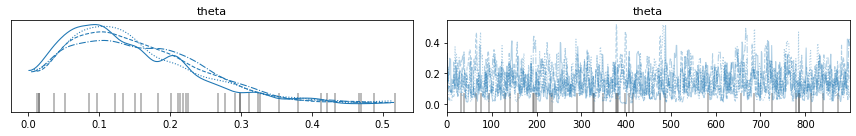

In [106]:
az.plot_trace(trace)
plt.tight_layout()

## Change of variable

In [137]:
jacobian_fn = jax.jacfwd(jax.nn.sigmoid)


def logprob_fn_change_of_var(params):

    # change of variable
    logit = params["logit"]
    theta = jax.nn.sigmoid(logit)
    jacob_logprob = jnp.log(jacobian_fn(logit))  # jacobian of sigmoid function at logit

    # log likelihood
    likelihood_log_prob = likelihood_dist(theta).log_prob(dataset).sum()

    # log prior
    prior_log_prob = prior_dist().log_prob(theta)
    return likelihood_log_prob + prior_log_prob + jacob_logprob

In [138]:
nuts = blackjax.nuts(logprob_fn_change_of_var, step_size, inv_mass_matrix)

In [139]:
n_chains = 4
rng_key = jax.random.PRNGKey(0)
# initial_positions = {"theta": jax.random.uniform(key = rng_key, shape=(n_chains,))}
initial_positions = {"logit": jnp.array([-1.0, -0.5, 0.5, 1.0])}
initial_states = jax.vmap(nuts.init)(initial_positions)
kernel = jax.jit(nuts.step)

In [140]:
%%time
n_samples = 1100
rng_key = jax.random.PRNGKey(1)
chain_states, infos = inference_loop_multiple_chains(rng_key, kernel, initial_states, n_samples, n_chains)

CPU times: user 4.7 s, sys: 18.4 ms, total: 4.72 s
Wall time: 4.66 s


In [141]:
chain_states.position["theta"] = jax.nn.sigmoid(chain_states.position["logit"])
del chain_states.position["logit"]

In [142]:
chains = chain_states.position["theta"]

In [143]:
chains.shape

(1100, 4)

In [144]:
trace = arviz_trace_from_states(chain_states, infos, burn_in=100)
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.149,0.095,0.004,0.319,0.003,0.002,688.0,793.0,1.0


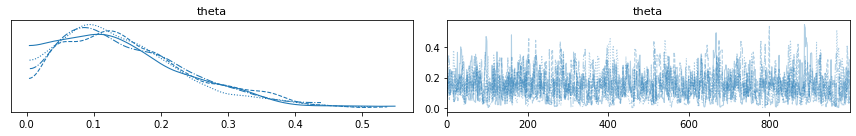

In [145]:
az.plot_trace(trace)
plt.tight_layout()

In [146]:
true_mean = (1 + dataset.sum()) / (2 + len(dataset))
true_mean

0.15384615384615385

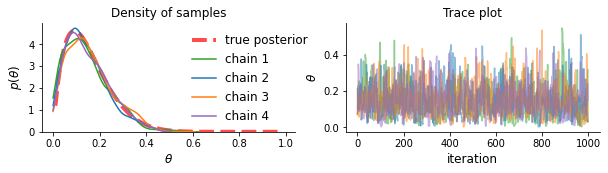

In [149]:
BURN = 100
LATEXIFY = "LATEXIFY" in os.environ
FIG_SIZE = (10, 2) if not LATEXIFY else None
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIG_SIZE)

ax1.set_title("Density of samples")
(plt2,) = ax1.plot(theta_range, posterior_prob, "r--", label="true posterior", lw=4, alpha=0.7)

colors = ["tab:green", "tab:blue", "tab:orange", "tab:purple"]
for no in range(n_chains):
    sns.kdeplot(chains[BURN:, no], ax=ax1, clip=(0.0, 1.0), label=f"chain {no+1}", color=colors[no])

ax1.set_xlabel("$\\theta$")
ax1.set_ylabel("$p(\\theta)$")


ax1.legend(bbox_to_anchor=(0.55, 1), frameon=False)
sns.despine()

ax2.set_title("Trace plot")
for no in range(n_chains):
    ax2.plot(chains[BURN:, no], label=f"chain {no+1}", alpha=0.5, color=colors[no])

ax2.set_xlabel("iteration")
ax2.set_ylabel("$\\theta$")
sns.despine()
savefig("bb_hmc_trace")  # to save figure set FIG_DIR="path/to/figure" enviornment variable